# Q2Vec

https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE/blob/master/Thrones2Vec.ipynb

Using only the raw English Translated text of the Holy Quran, we'll derive and explore the semantic properties of its words.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suhailahamed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suhailahamed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("qtxt/*.txt"))

In [8]:
print("Found files:")
book_filenames

Found files:


['qtxt/English-A.-J.-Arberry-101.txt',
 'qtxt/English-Ahmed-Ali-100.txt',
 'qtxt/English-Ali-Ünal-97.txt',
 'qtxt/English-Amatul-Rahman-Omar-98.txt',
 'qtxt/English-Daryabadi-102.txt',
 'qtxt/English-Faridul-Haque-106.txt',
 'qtxt/English-Hamid-S.-Aziz-105.txt',
 'qtxt/English-Maulana-Mohammad-Ali-103.txt',
 'qtxt/English-Muhammad-Sarwar-104.txt',
 'qtxt/English-Pickthall-60.txt',
 'qtxt/English-Shakir-58.txt',
 'qtxt/English-Yusuf-Ali-59.txt',
 'qtxt/q1.txt',
 'qtxt/q2.txt']

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()
corpus_raw = corpus_raw.lower()

Reading 'qtxt/English-A.-J.-Arberry-101.txt'...
Corpus is now 907589 characters long

Reading 'qtxt/English-Ahmed-Ali-100.txt'...
Corpus is now 1709177 characters long

Reading 'qtxt/English-Ali-Ünal-97.txt'...
Corpus is now 2936672 characters long

Reading 'qtxt/English-Amatul-Rahman-Omar-98.txt'...
Corpus is now 4092198 characters long

Reading 'qtxt/English-Daryabadi-102.txt'...
Corpus is now 4949490 characters long

Reading 'qtxt/English-Faridul-Haque-106.txt'...
Corpus is now 5862921 characters long

Reading 'qtxt/English-Hamid-S.-Aziz-105.txt'...
Corpus is now 6738522 characters long

Reading 'qtxt/English-Maulana-Mohammad-Ali-103.txt'...
Corpus is now 7544427 characters long

Reading 'qtxt/English-Muhammad-Sarwar-104.txt'...
Corpus is now 8389879 characters long

Reading 'qtxt/English-Pickthall-60.txt'...
Corpus is now 9224555 characters long

Reading 'qtxt/English-Shakir-58.txt'...
Corpus is now 10077638 characters long

Reading 'qtxt/English-Yusuf-Ali-59.txt'...
Corpus is now 

**Split the corpus into sentences**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[80])
print(sentence_to_wordlist(raw_sentences[80]))

yet it may happen that you will hate a thing which is better for you; and it may happen that you will love a thing which is worse for you; god knows, and you know not.´)
 (101,2,217,217,n´they will question thee concerning the holy month, and fighting in it.
['yet', 'it', 'may', 'happen', 'that', 'you', 'will', 'hate', 'a', 'thing', 'which', 'is', 'better', 'for', 'you', 'and', 'it', 'may', 'happen', 'that', 'you', 'will', 'love', 'a', 'thing', 'which', 'is', 'worse', 'for', 'you', 'god', 'knows', 'and', 'you', 'know', 'not', 'n', 'they', 'will', 'question', 'thee', 'concerning', 'the', 'holy', 'month', 'and', 'fighting', 'in', 'it']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 2,547,595 tokens


## Train Word2Vec

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 42

In [17]:
q2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
q2vec.build_vocab(sentences)

2019-02-22 16:39:11,127 : INFO : collecting all words and their counts
2019-02-22 16:39:11,130 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-22 16:39:11,236 : INFO : PROGRESS: at sentence #10000, processed 296697 words, keeping 8246 word types
2019-02-22 16:39:11,317 : INFO : PROGRESS: at sentence #20000, processed 513974 words, keeping 10615 word types
2019-02-22 16:39:11,391 : INFO : PROGRESS: at sentence #30000, processed 740903 words, keeping 12461 word types
2019-02-22 16:39:11,446 : INFO : PROGRESS: at sentence #40000, processed 921218 words, keeping 14150 word types
2019-02-22 16:39:11,519 : INFO : PROGRESS: at sentence #50000, processed 1147763 words, keeping 15035 word types
2019-02-22 16:39:11,580 : INFO : PROGRESS: at sentence #60000, processed 1331708 words, keeping 15418 word types
2019-02-22 16:39:11,643 : INFO : PROGRESS: at sentence #70000, processed 1488455 words, keeping 15761 word types
2019-02-22 16:39:11,698 : INFO : PROGRESS: a

In [19]:
print("Word2Vec vocabulary length:", len(q2vec.wv.vocab))

Word2Vec vocabulary length: 11989


**Start training, this might take a minute or two...**

In [20]:
q2vec.train(sentences, total_examples=35201, epochs=10)

2019-02-22 16:39:12,513 : INFO : training model with 4 workers on 11989 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-02-22 16:39:13,584 : INFO : EPOCH 1 - PROGRESS: at 20.10% examples, 157767 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:39:14,623 : INFO : EPOCH 1 - PROGRESS: at 58.74% examples, 168737 words/s, in_qsize 8, out_qsize 0
2019-02-22 16:39:15,664 : INFO : EPOCH 1 - PROGRESS: at 109.55% examples, 189955 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:39:16,706 : INFO : EPOCH 1 - PROGRESS: at 143.36% examples, 185556 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:39:17,708 : INFO : EPOCH 1 - PROGRESS: at 200.49% examples, 193116 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:39:18,756 : INFO : EPOCH 1 - PROGRESS: at 259.04% examples, 200109 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:39:19,780 : INFO : EPOCH 1 - PROGRESS: at 304.99% examples, 198148 words/s, in_qsize 6, out_qsize 1
2019-02-22 16:39:20,867 : INFO : EPOCH 1 - PROGRESS: a

2019-02-22 16:40:02,809 : INFO : EPOCH - 5 : training on 2547595 raw words (1710120 effective words) took 10.5s, 162201 effective words/s
2019-02-22 16:40:02,810 : WARNING : EPOCH - 5 : supplied example count (126385) did not equal expected count (35201)
2019-02-22 16:40:03,849 : INFO : EPOCH 6 - PROGRESS: at 27.00% examples, 187908 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:40:04,870 : INFO : EPOCH 6 - PROGRESS: at 63.20% examples, 185605 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:40:05,907 : INFO : EPOCH 6 - PROGRESS: at 107.53% examples, 190783 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:40:06,961 : INFO : EPOCH 6 - PROGRESS: at 146.13% examples, 190334 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:40:08,001 : INFO : EPOCH 6 - PROGRESS: at 196.46% examples, 190473 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:40:09,005 : INFO : EPOCH 6 - PROGRESS: at 248.37% examples, 193013 words/s, in_qsize 7, out_qsize 0
2019-02-22 16:40:10,020 : INFO : EPOCH 6 - PROGRESS: at 298.70%

(17100856, 25475950)

**Save to file, can be useful later**

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
q2vec.save(os.path.join("trained", "q2vec.w2v"))

2019-02-22 16:40:42,722 : INFO : saving Word2Vec object under trained/q2vec.w2v, separately None
2019-02-22 16:40:42,725 : INFO : not storing attribute vectors_norm
2019-02-22 16:40:42,730 : INFO : not storing attribute cum_table
2019-02-22 16:40:43,051 : INFO : saved trained/q2vec.w2v


## Explore the trained model.

In [23]:
q2vec = w2v.Word2Vec.load(os.path.join("trained", "q2vec.w2v"))

2019-02-22 16:40:43,063 : INFO : loading Word2Vec object from trained/q2vec.w2v
2019-02-22 16:40:43,599 : INFO : loading wv recursively from trained/q2vec.w2v.wv.* with mmap=None
2019-02-22 16:40:43,600 : INFO : setting ignored attribute vectors_norm to None
2019-02-22 16:40:43,600 : INFO : loading vocabulary recursively from trained/q2vec.w2v.vocabulary.* with mmap=None
2019-02-22 16:40:43,601 : INFO : loading trainables recursively from trained/q2vec.w2v.trainables.* with mmap=None
2019-02-22 16:40:43,603 : INFO : setting ignored attribute cum_table to None
2019-02-22 16:40:43,604 : INFO : loaded trained/q2vec.w2v


### Compress the word vectors into 2D space and plot them

In [24]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
all_word_vectors_matrix = q2vec.wv.syn0

/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


**Train t-SNE, this could take a minute or two...**

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[q2vec.wv.vocab[word].index])
            for word in q2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [28]:
points.head(10)

,word,x,y
0,n,25.451092,30.097408
1,in,1.372635,13.172627
2,the,-22.896374,-2.835305
3,name,-21.045771,-58.656296
4,of,-22.796614,-2.372835
5,god,-16.863775,44.310616
6,merciful,-24.046879,53.512550
7,compassionate,-24.135984,53.421825
8,praise,-53.196609,-27.663857
9,belongs,-31.422659,49.044018


In [29]:
sns.set_context("poster")

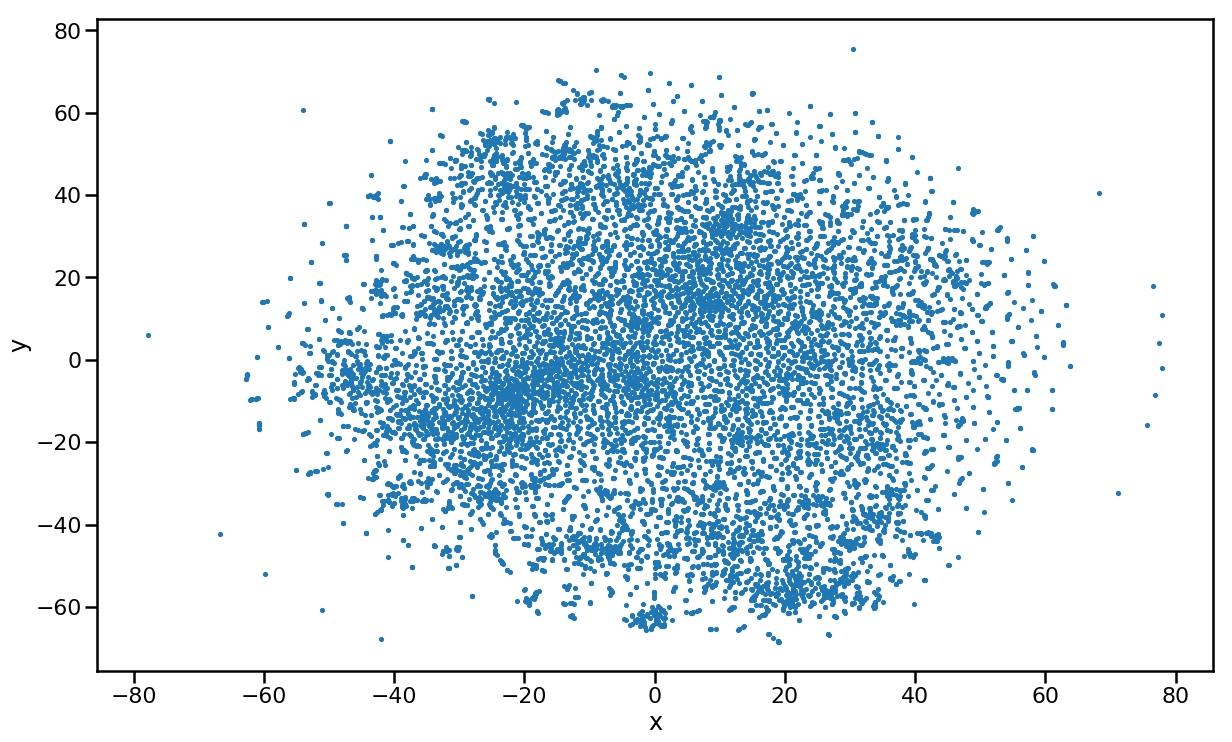

In [30]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [31]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**The biblical Prophets/places**

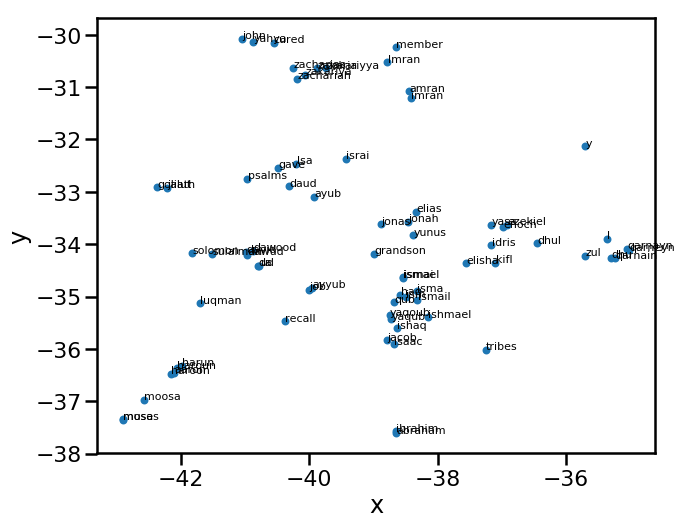

In [107]:
plot_region(x_bounds=(-43, -35), y_bounds=(-40, -30))

**Human Creation words close together**

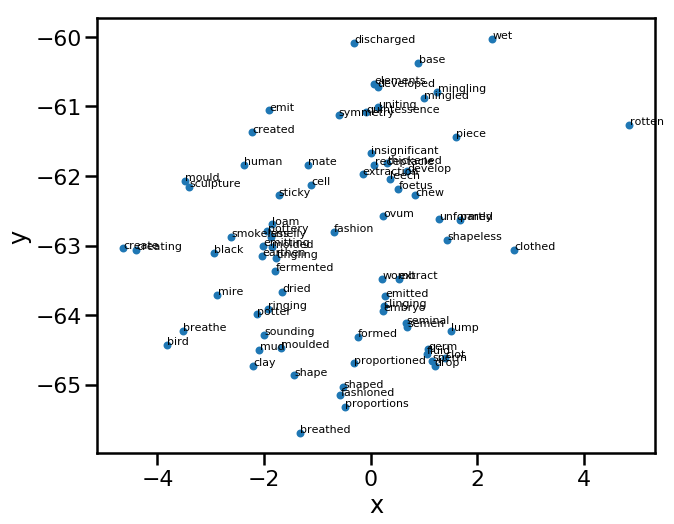

In [93]:
plot_region(x_bounds=(-5.0, 5.0), y_bounds=(-30.0, -60.0))

**Charity related and people who require them**

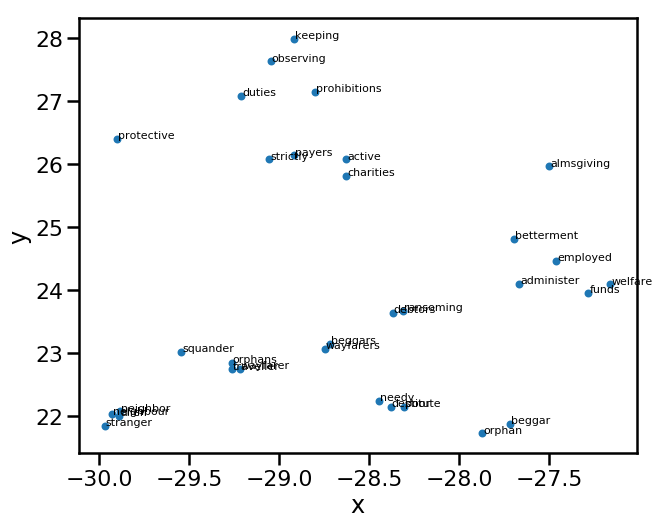

In [92]:
plot_region(x_bounds=(-30, -27), y_bounds=(21, 28))

**Looks like descriptions of Hell**

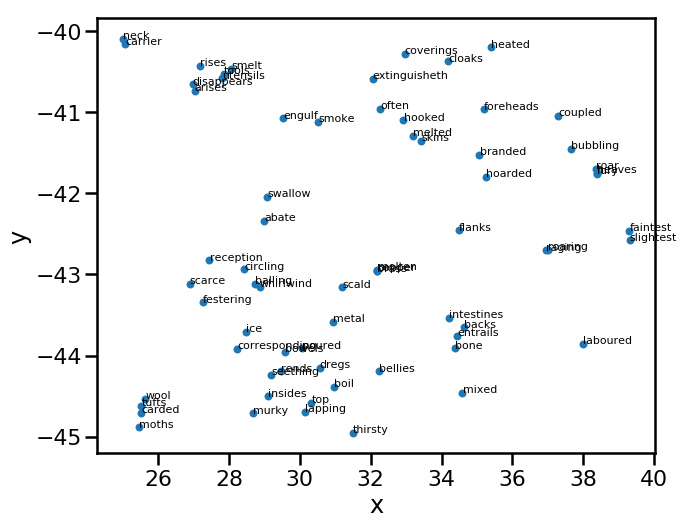

In [123]:
plot_region(x_bounds=(25, 40), y_bounds=(-45, -40))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [99]:
q2vec.wv.most_similar("moses")

[('musa', 0.7518500685691833),
 ('moosa', 0.7021316289901733),
 ('aaron', 0.5574465990066528),
 ('haroun', 0.5193570852279663),
 ('haroon', 0.5011561512947083),
 ('request', 0.49032485485076904),
 ('indignant', 0.48001348972320557),
 ('harun', 0.475777268409729),
 ('rod', 0.46696901321411133),
 ('deliberating', 0.45517435669898987)]

In [98]:
q2vec.wv.most_similar("hell")

[('gehenna', 0.7765553593635559),
 ('destination', 0.5595409870147705),
 ('flaming', 0.5457025170326233),
 ('blazing', 0.5430545806884766),
 ('fire', 0.5338244438171387),
 ('roast', 0.5165133476257324),
 ('blaze', 0.5077469348907471),
 ('hapless', 0.4895065128803253),
 ('burning', 0.4807415008544922),
 ('abates', 0.4702552258968353)]

In [184]:
q2vec.wv.most_similar("elephant")

[('iram', 0.7517645359039307),
 ('elephants', 0.7172006368637085),
 ('columned', 0.7134018540382385),
 ('abrahah', 0.6940048933029175),
 ('stakes', 0.6752783060073853),
 ('ashab', 0.6665158867835999),
 ('cyrus', 0.6568741798400879),
 ('aram', 0.6423631906509399),
 ('inserted', 0.6420777440071106),
 ('byzantines', 0.6386557817459106)]

In [200]:
q2vec.wv.most_similar("creator")

[('sustainer', 0.6535698175430298),
 ('subduer', 0.6291631460189819),
 ('preserver', 0.6173883080482483),
 ('fashioner', 0.6077768802642822),
 ('shaper', 0.6063218116760254),
 ('sovereign', 0.6040071249008179),
 ('maker', 0.6004970073699951),
 ('maintains', 0.5805596709251404),
 ('controller', 0.5775657892227173),
 ('originator', 0.5707967281341553)]

In [203]:
q2vec.wv.most_similar("ilyas")

[('elijah', 0.9191354513168335),
 ('yunus', 0.8281607627868652),
 ('rasul', 0.8122850656509399),
 ('nabi', 0.7999380826950073),
 ('tolerant', 0.7900214791297913),
 ('elias', 0.7890276908874512),
 ('maqam', 0.7884913086891174),
 ('progenitor', 0.7817249298095703),
 ('yasa', 0.7816395163536072),
 ('hazrat', 0.7776193618774414)]